# Local Arakawa A-grid - Forward tracking

Arakawa A-grids are common in ocean modelling. It is often a requirement that data submitted to public data repositories, such as the Copernicus Marine Environment Monitoring Service (CMEMS), are defined on an Arakawa A-grid. They are one of the simpler types of grid used in ocean modelling, in which all variables are defined at the same points in space. Here, we demonstrate how to use *PyLag* with inputs defined on an Arakawa A-grid in a forward tracking experiment.The grid is local in its coverage, with open boundaries along its edges. An experiment that uses a global Arakawa A-grid is given [next example](./global_arakawa_a_forward_tracking.ipynb).

In order to complement the forward tracking example using raw Finite Volume Community Ocean Model (FVCOM) outputs, here we use outputs from the same FVCOM model run, but interpolated onto a standard Arakawa A-grid. We release particles from the same locations in space and time. However, here we work in *geographic coordinates* rather than *Cartesian coordinates*, as was the case in the FVCOM forward tracking experiment.

As is the case in the other examples, the output files needed to run the experiment can be [downloaded here](https://drive.google.com/open?id=15UX7Y9JnuLpnPAz700mzmzd917nTClxR) If you would like to run the code in this notebook interactively, download the data into a directory of your chooising. By default, the notebook will look for these files in the directory `${HOME}/data/pylag_doc`. To change this, simply update the *data_dir* path below.

In [1]:
import os

# Root directory for PyLag example input files
data_dir='{}/data/pylag_doc'.format(os.environ['HOME'])

## Setting particle initial positions

We will create an initial position file in which to record [particle initial positions](../documentation/initial_positions.ipynb). This will be read in by *PyLag*, and used to create the initial particle seed. The initial location of particles will be identical to those used in the [FVCOM forward tracking experiment](./fvcom_forward_tracking.ipynb), but with particle positions defined in polar coordinates rather than Cartesian coordinates. To achieve this, we first create the release zone as before, then convert to polar coordinates.

In [2]:
import os

from pylag.processing.coordinate import utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zone
from pylag.processing.input import create_initial_positions_file_single_group

# Keep a copy of the cwd
cwd = os.getcwd()

# Create run directory
simulation_dir = '{}/simulations/arakawa_a_forward'.format(cwd)
try:
    os.makedirs(simulation_dir)
except FileExistsError:
    pass

# The group ID of this particle set
group_id = 1

# Lat and lon coordiantes for the centre of the release zone
lat = 50.32
lon = -4.17

# Convert to UTM coordinates
easting, northing, _ = utm_from_lonlat([lon], [lat], zone='30N')

# Release zone radius (m)
radius = 200.0

# Target number of particles to be released. Only a target,
# since we are evenly distributing particles in the release
# zone, which has no unique solution.
n_particles_target = 100

# Release depths
depth_below_surface = 0.0

# Create the release zone
surface_release_zone = create_release_zone(group_id = group_id,
                                           radius = radius,
                                           centre = [easting, northing],
                                           n_particles = n_particles_target,
                                           depth = depth_below_surface,
                                           random = False)

# Get the actual number of particles
n_particles = surface_release_zone.get_number_of_particles()

# Convert to lat/lon coordinates
lons, lats = lonlat_from_utm(surface_release_zone.get_eastings(),
                             surface_release_zone.get_northings(),
                             '30N')

# Get depths
depths = surface_release_zone.get_depths()

# Create input sub-directory
input_dir = '{}/input'.format(simulation_dir)
try:
    os.makedirs(input_dir)
except FileExistsError:
    pass

# Output filename
file_name = '{}/initial_positions.dat'.format(input_dir)

# Write data to file
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           lons,
                                           lats,
                                           depths)

## Creating an Arakawa A grid metrics file

[Outputs](https://data.ecosystem-modelling.pml.ac.uk/thredds/catalog/mycoast-all-files/Model/FVCOM/tamar/catalog.html) from the Western Channel Observatory operational forecast (WCOOF) model are interpolated onto an Arakawa A-grid and made available for public use via a [THREDDS Data Server](https://www.unidata.ucar.edu/software/tds/current/). This is a standard processing step for coastal high resolution forecast systems that have been developed within the [MyCoast](http://mycoast-project.org/) Interreg project.

Internally, *PyLag* treats all grids as being unstructured. In order to work with data defined on an Arakawa A-grid, it is necessary to first create an unstructured representation. Grid variables that describe the unstructured grid are stored in a grid metrics file, which is read in by *PyLag* during the model initialisation phase. A grid metrics file has been pre-created and is shipped with the input data. However, for completeness, here we will recreate a new grid metrics file from the input data.

In [3]:
from pylag.grid_metrics import create_arakawa_a_grid_metrics_file

# An example Arakawa A output file
arakawa_a_file_name = '{}/arakawa_a_tamar_estuary_0001.nc'.format(data_dir)

# The name of the output file
grid_metrics_file_name = '{}/grid_metrics.nc'.format(input_dir)

# Generate the file
create_arakawa_a_grid_metrics_file(arakawa_a_file_name,
                                   lon_var_name='longitude',
                                   lat_var_name='latitude',
                                   depth_var_name='depth',
                                   mask_var_name='mask',
                                   bathymetry_var_name='h',
                                   grid_metrics_file_name=grid_metrics_file_name)

Reading the grid:
Reading variable `longitude` ... done
Reading variable `latitude` ... done
Reading variable `depth` ... done

Creating the triangulation ... done

Generating the bathymetry:
Reading variable `h` ... done
Sorting axes for variable `h`... done

Generating the land sea mask at element nodes:
Reading variable `mask` ... done
Sorting axes for variable `mask`... done

Sorting the adjacency array ... done

Calculating lons and lats at element centres ... done

Generating land sea mask at element centres ... done

Mask elements with two land boundaries ... done

Flagging open boundaries ... done

Creating grid metrics file /home/jcl/code/git/PyLag/PyLag/doc/source/examples/simulations/arakawa_a_forward/input/grid_metrics.nc ... done


It is possible to visualise the unstructured grid, created from the underlying Arakawa A-grid, in the following way.

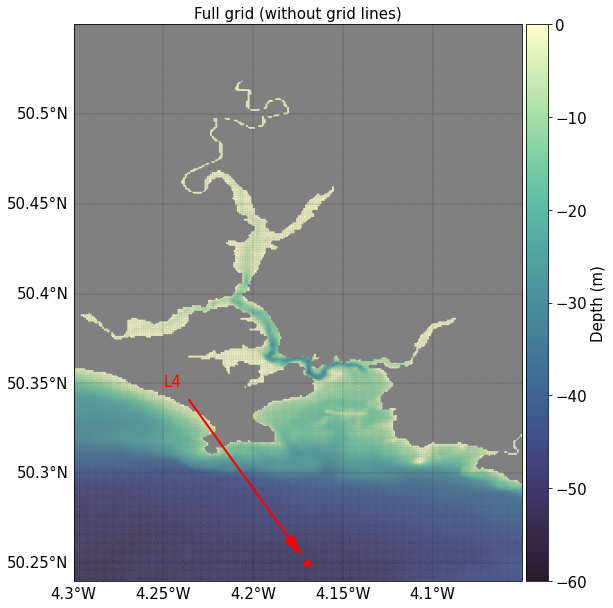

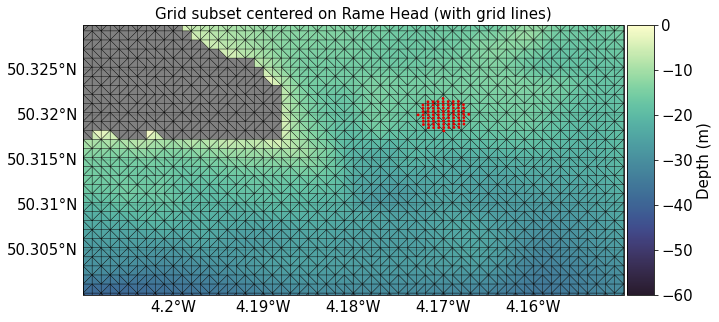

In [4]:
import warnings
import os
import numpy as np
from netCDF4 import Dataset
import cartopy.crs as ccrs

from pylag.processing.plot import ArakawaAPlotter
from pylag.processing.plot import create_figure, colourmap

warnings.filterwarnings('ignore')

# Read in the bathymetry
ds = Dataset(grid_metrics_file_name, 'r')
bathy = -ds.variables['h'][:]
ds.close()
del(ds)

# Full grid
# ---------

# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Configure plotter
plotter = ArakawaAPlotter(grid_metrics_file_name,
                          font_size=font_size)

# Plot the bathymetry
extents = None
plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                   vmin=-60., vmax=0., cmap=cmap)

# Mark location of Station L4
plotter.scatter(ax, [-4.17], [50.25], marker='o', c='r')
x, y = ax.projection.transform_point(-4.17, 50.25, src_crs=ccrs.PlateCarree())
ax.annotate('L4', xy=(x, y), xytext=(0.2, 0.35), textcoords='axes fraction',
             arrowprops=dict(facecolor='red', edgecolor='red', width=1, headwidth=10, headlength=20, shrink=0.05),
             fontsize=font_size, color='red')
plotter.set_title(ax, 'Full grid (without grid lines)')

# Grid subset (centered on Rame Head)
# -----------------------------------

# Create figure
font_size = 15
cmap = colourmap('h_r')
fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Configure plotter
plotter = ArakawaAPlotter(grid_metrics_file_name,
                          font_size=font_size)

# Plot bathymetry
extents = np.array([-4.21, -4.15, 50.30, 50.33], dtype=float)
plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                   vmin=-60., vmax=0., cmap=cmap)

# Overlay grid
plotter.draw_grid(ax, linewidth=0.25, draw_masked_elements=True)

# Plot particle initial positions
plotter.scatter(ax, lons, lats, s=8, color='#e50000', edgecolors='none')

# Set title
plotter.set_title(ax, 'Grid subset centered on Rame Head (with grid lines)')

The first plot shows the full model domain. In contrast to the FVCOM grids used in other examples, which only contain valid unmasked cells, here the unstructured grid includes both *masked* (shown in grey) and *unmasked* cells. An outline of the unstructured grid is shown in the second figure (blue lines), where it can clearly be seen the grid extends over both sea and land. What is also evident is the uniform sizing of elements, which again is in contrast to the original FVCOM grid we worked with. The uniform grid sizing is a natural consequence of reinterpreting the regular Arakawa A-grid as an unstructured triangular grid. Relative to the original FVCOM grid, the uniform element sizing has yielded a coarser representation of the flow field near to the coast and within the estuary, and a finer representation of the field in the English Channel. Also shown in the second figure is the initial position of particles (red dots), which match those used in the [FVCOM forward tracking experiment](./fvcom_forward_tracking.ipynb).

## Creating the run configuration file

As before, a [run configuration](../documentation/configuration.ipynb) file has been provided. We will use configparser to look at some settings specific to the example. First, we read in the file, then we print out some of the key options for the run:

In [5]:
import configparser

config_file_name = './configs/arakawa_a_forward_template.cfg'

cf = configparser.ConfigParser()
cf.read(config_file_name)

# Start time
print('Start time: {}'.format(cf.get('SIMULATION', 'start_datetime')))

# End time
print('End time: {}'.format(cf.get('SIMULATION', 'end_datetime')))

# Specify that this is a forward tracking experiment
print('Time direction: {}'.format(cf.get('SIMULATION', 'time_direction')))

# We will do a single run, rather than an ensemble run
print('Number of particle releases: {}'.format(cf.get('SIMULATION', 'number_of_particle_releases')))

# Use depth restoring, and restore particle depths to the ocean surface
print('Use depth restoring: {}'.format(cf.get('SIMULATION', 'depth_restoring')))
print('Restore particles to a depth of: {} m'.format(cf.get('SIMULATION', 'fixed_depth')))

# Specify that we are working with Arakawa A-grid in geographic coordinates
print('Model name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'name')))
print('Coordinate system: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'coordinate_system')))

# Set the location of the grid metrics and input files
print('Data directory: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'data_dir')))
print('Path to grid metrics file: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file')))
print('File name stem of input files: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'data_file_stem')))

Start time: 2020-05-02 03:00:00
End time: 2020-05-02 18:00:00
Time direction: forward
Number of particle releases: 1
Use depth restoring: True
Restore particles to a depth of: 0.0 m
Model name: ArakawaA
Coordinate system: geographic
Data directory: 
Path to grid metrics file: 
File name stem of input files: arakawa_a_tamar_estuary_0


The start and end times are identical to those used in the [FVCOM forward tracking experiment](./fvcom_forward_tracking.ipynb). As before, we are restoring particle positions to the ocean surface. The `name` option is used to tell PyLag it will be working with input data defined on an Arakawa A-grid, while the `coordinate_system` option is used to specify that variables are defined on a lat/lon grid. As before, the data directory and path to the grid metrics file have not yet been set.

When working with data on Arakawa A-grids, one must provide the names of NetCDF dimensions and variables used in the input data. In this example, the input dataset adheres to [CMOR](https://cmor.llnl.gov/) standards and naming conventions. Some of the key dimension and variable names for this example are:

In [6]:
print('Dimensions\n')
print('Time dimension name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'time_dim_name')))
print('Depth dimension name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'depth_dim_name')))
print('Latitude dimension name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'latitude_dim_name')))
print('Longitude dimension name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'longitude_dim_name')))

print('\nVariables\n')
print('Time variable name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'time_var_name')))
print('uo variable name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'uo_var_name')))
print('vo variable name: {}'.format(cf.get('OCEAN_CIRCULATION_MODEL', 'vo_var_name')))

Dimensions

Time dimension name: time
Depth dimension name: depth
Latitude dimension name: latitude
Longitude dimension name: longitude

Variables

Time variable name: time
uo variable name: uo
vo variable name: vo


We will now set `data_dir` and the path to the grid metrics file, and save the new config file in the simulation directory.

In [7]:
cf.set('OCEAN_CIRCULATION_MODEL', 'data_dir', data_dir)
cf.set('OCEAN_CIRCULATION_MODEL', 'grid_metrics_file', grid_metrics_file_name)

# Save a copy in the simulation directory
with open("{}/pylag.cfg".format(simulation_dir), 'w') as config:
    cf.write(config)

## Running the model

With the run configuration file saved, we can now run the example. While PyLag can be used interactivatly, it is most commonly launched from the command line. A small driver script has been provided, which we will use here to launch *PyLag*.

In [8]:
import subprocess

# Change to the run directory and launch
os.chdir('{}'.format(simulation_dir))

try:
    subprocess.call(['./run.sh'])
except:
    print('Run failed.')
    pass

# Return to the cwd
os.chdir(cwd)

## Visualising the result

With the model having run, the final step is to visulise the result. Here, we produce a simple plot of particle pathlines over the course of the simulation.

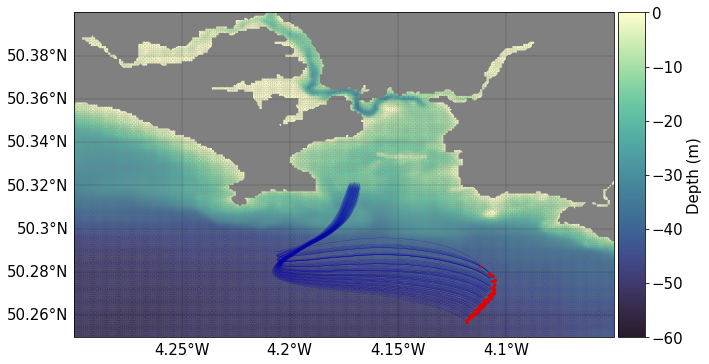

In [9]:
from datetime import timedelta

from pylag.processing.ncview import Viewer


file_name = '{}/output/pylag_1.nc'.format(simulation_dir)

# Time of flight
time_of_flight = timedelta(hours=15)

# Plot extents
extents = np.array([-4.3, -4.05, 50.25, 50.4], dtype=float)

fig, ax = create_figure(figure_size=(26., 26.), projection=ccrs.PlateCarree(), font_size=font_size, bg_color='gray')

# Create plot of release 
plotter = ArakawaAPlotter(grid_metrics_file_name,
                          font_size=font_size)

# Plot the bathymetry again. We'll overlay pathlines on top of this.
plotter.plot_field(ax, bathy, extents=extents, add_colour_bar=True, cb_label='Depth (m)',
                   vmin=-60., vmax=0., cmap=cmap)

# Dataset holding particle positions
viewer = Viewer(file_name, time_rounding=900)

# Get time index
date = viewer.date[0] + time_of_flight
time_index = viewer.date.tolist().index(date)

# Plot particle final positions
ax, scatter = plotter.scatter(ax, viewer('longitude')[time_index, :].squeeze(),
                     viewer('latitude')[time_index, :].squeeze(),
                     s=8, color='#e50000', edgecolors='none')

# Add path lines
ax, lines = plotter.plot_lines(ax, viewer('longitude')[:time_index, :],
                               viewer('latitude')[:time_index, :],
                               linewidth=0.15, alpha=1,
                               color='#0504aa')

The pathlines can be seen to closely follow those simulated in the [FVCOM forward tracking experiment](./fvcom_forward_tracking.ipynb). Note we would not expect the match to be exact, given the two sets input data are defined on two different grids with contrasting spatial resolution.